# 얼굴 인식을 사용한 사람인식 학습
- 프로젝트에 필요한 팀원 2명의 얼굴 데이터(2개의 서보모터에 대응) + lfw 얼굴 데이터셋 중 50개 이상의 이미지가 있는 인물만을 추가로 학습데이터에 적용

In [1]:
import os
import cv2
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
%matplotlib inline

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

In [61]:
#데이터셋 폴더 지정

dataset_folder = "dataset/"

In [ ]:
cap = cv2.VideoCapture(0)

my_name = "KeonHee_Jeong"
os.mkdir(dataset_folder + my_name)
num_sample = 50

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if ret :
        cv2.imshow("Capture Photo", frame)
        cv2.imwrite("dataset/%s/%s_%04d.jpg" %  (my_name, my_name, i), cv2.resize(frame, (250,250)))
        
        if cv2.waitKey(100) == ord('q') or i == num_sample:
            break
        i += 1    
cap.release()
cv2.destroyAllWindows()

# 1. 얼굴 인식(Face Recognition using (Convolution Neural Network)) - CNN

추가적으로 데이터셋을 적용했습니다.
- Download Dataset : 
    - LFW(유명 정치인 등의 실제 얼굴에 대한 이미지 데이터) : http://vis-www.cs.umass.edu/lfw/

In [4]:
def detect_face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [5]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [6]:
names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img) # detect face using mtcnn and crop to 100x100
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (77 samples)	 label : Ariel_Sharon 		


[####################] (150 samples)	 label : Colin_Powell 		
[####################] (121 samples)	 label : Donald_Rumsfeld 		


[####################] (150 samples)	 label : George_W_Bush 		
[####################] (109 samples)	 label : Gerhard_Schroeder 		


[####################] (71 samples)	 label : Hugo_Chavez 		
[####################] (52 samples)	 label : Jacques_Chirac 		
[####################] (55 samples)	 label : Jean_Chretien 		


[####################] (53 samples)	 label : John_Ashcroft 		
[####################] (60 samples)	 label : Junichiro_Koizumi 		
[####################] (92 samples)	 label : KeonHee_Jeong 		


[####################] (81 samples)	 label : KyungSoo_Jeong 		
[####################] (52 samples)	 label : Serena_Williams 		


In [7]:
print("number of samples :", len(names))

number of samples : 1267


이미지 데이터 늘리기
- 적은 이미지 데이터를 늘리기 위해 이미지를 회전 시키거나 옆으로 움직이거나 색을 바꿔 데이터 샘플 수를 늘림.

In [8]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

- 증가된 데이터 출력 테스트

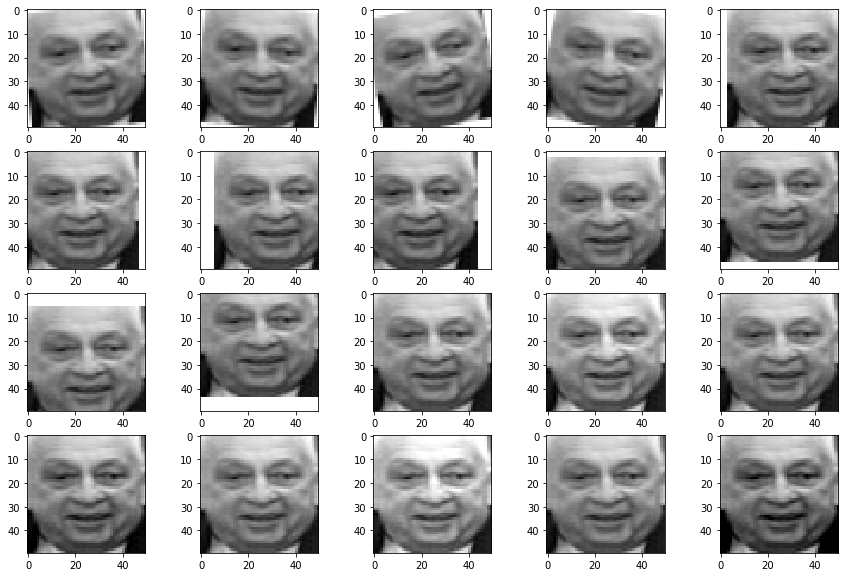

In [9]:
img_test = images[1]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

- 늘린 데이터 적용

In [10]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [11]:
len(augmented_images), len(augmented_names)

(25340, 25340)

In [12]:
images.extend(augmented_images)
names.extend(augmented_names)

- 기존 이미지에 늘린 이미지 추가

In [13]:
len(images), len(names)

(26607, 26607)

In [14]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Ariel_Sharon', 1617)
('Colin_Powell', 3150)
('Donald_Rumsfeld', 2541)
('George_W_Bush', 3150)
('Gerhard_Schroeder', 2289)
('Hugo_Chavez', 1491)
('Jacques_Chirac', 1092)
('Jean_Chretien', 1155)
('John_Ashcroft', 1113)
('Junichiro_Koizumi', 1260)
('KeonHee_Jeong', 1932)
('KyungSoo_Jeong', 1701)
('Serena_Williams', 1092)
('Tony_Blair', 3024)


### 1.1.B Balancing Data

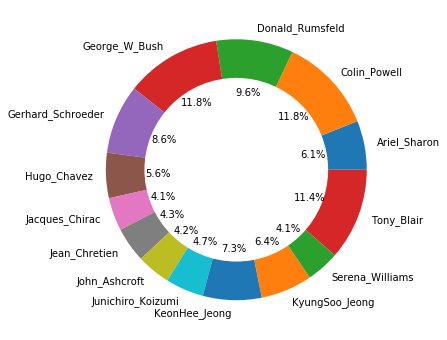

In [15]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [16]:
# reduce sample size per-class using numpy random choice
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [17]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

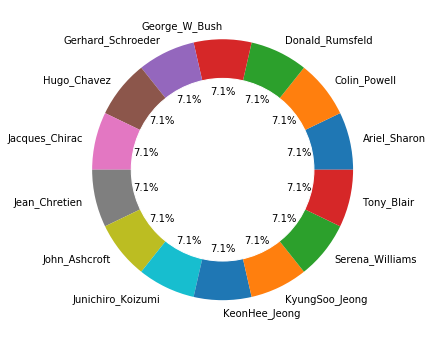

In [18]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

### 1.2 Encoding Label & Categoricalization

In [19]:
# 아래에서 numpy Array가 아닌 인코딩 된 리스트를 사용해 서보 모터 돌리는 코드를 쓰기 때문에 
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [20]:
print("number of class :", len(labels))
print(labels)

number of class : 14
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien'
 'John_Ashcroft' 'Junichiro_Koizumi' 'KeonHee_Jeong' 'KyungSoo_Jeong'
 'Serena_Williams' 'Tony_Blair']


In [21]:
print(name_vec)

[ 0  0  0 ... 13 13 13]


In [22]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


- 학습 데이터, 테스트 데이터 0.85 : 0.15로 분할

In [23]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [24]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(11900, 50, 50) (11900, 14) (2100, 50, 50) (2100, 14)


- 데이터 reshape

In [25]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [26]:
x_train.shape, x_test.shape

((11900, 50, 50, 1), (2100, 50, 50, 1))

### Create CNN Model 생성

In [50]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation="relu")) # 원래는 128, 64였음 -> 모델 비교용으로 변경
    model.add(Dense(32, activation="relu"))
    model.add(Dense(len(labels)))   # len(labels)는 데이터 갯수 길이 
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

### Training CNN Model 학습

In [51]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)            

In [52]:
history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Epoch 1/10
317/317 [==============================] - 4s 10ms/step - loss: 3.1267 - accuracy: 0.1907 - val_loss: 1.4253 - val_accuracy: 0.5613
Epoch 2/10
317/317 [==============================] - 3s 10ms/step - loss: 1.1956 - accuracy: 0.6220 - val_loss: 0.7842 - val_accuracy: 0.7585
Epoch 3/10
317/317 [==============================] - 3s 10ms/step - loss: 0.6433 - accuracy: 0.7914 - val_loss: 0.7493 - val_accuracy: 0.7574
Epoch 4/10
317/317 [==============================] - 3s 10ms/step - loss: 0.4759 - accuracy: 0.8445 - val_loss: 0.4082 - val_accuracy: 0.8700
Epoch 5/10
317/317 [==============================] - 3s 10ms/step - loss: 0.3307 - accuracy: 0.8919 - val_loss: 0.3583 - val_accuracy: 0.8919
Epoch 6/10
317/317 [==============================] - 3s 10ms/step - loss: 0.2341 - accuracy: 0.9216 - val_loss: 0.3393 - val_accuracy: 0.8986
Epoch 7/10
317/317 [==============================] - 3s 10ms/step - loss: 0.2114 - accuracy: 0.9332 - val_loss: 0.4362 - val_accuracy: 0.8840

# 모델 예측 및 평가

KeyError: 'acc'

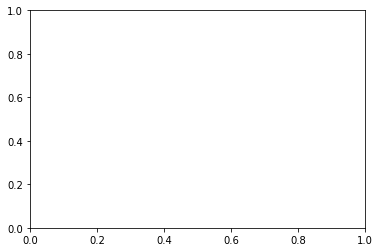

In [53]:
def evaluate_model_(history):
    names = [['acc', 'val_acc'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

- save model

In [54]:
model.save("model-cnn-facerecognition.h5")

- predict to all test dataset

In [55]:
# predict test data
y_pred=model.predict(x_test)

In [56]:
print(y_pred.argmax(axis=1))

[ 2  3  0 ... 13  5  9]


In [57]:
model = load_model("model-cnn-facerecognition.h5")

NameError: name 'load_model' is not defined

- plot confusion matrix 함수를 만들고 적용

In [62]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

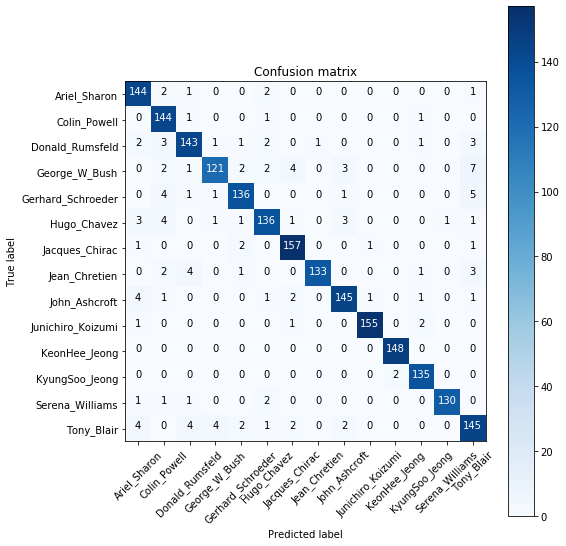

In [59]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


- Calculate metric report menggunakan `classification_report()` pada `scikit-learn` 

In [60]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.90      0.96      0.93       150
     Colin_Powell       0.88      0.98      0.93       147
  Donald_Rumsfeld       0.92      0.91      0.91       157
    George_W_Bush       0.95      0.85      0.90       142
Gerhard_Schroeder       0.94      0.92      0.93       148
      Hugo_Chavez       0.93      0.90      0.91       151
   Jacques_Chirac       0.94      0.97      0.95       162
    Jean_Chretien       0.99      0.92      0.96       144
    John_Ashcroft       0.94      0.93      0.94       156
Junichiro_Koizumi       0.99      0.97      0.98       159
    KeonHee_Jeong       0.99      1.00      0.99       148
   KyungSoo_Jeong       0.96      0.99      0.97       137
  Serena_Williams       0.99      0.96      0.98       135
       Tony_Blair       0.87      0.88      0.88       164

         accuracy                           0.94      2100
        macro avg       0.94      0.94      0.94      

In [ ]:
x_train = pd.DataFrame(x_train, columns = x.columns)

# VideoCapture로 Video Frame을 받아 얼굴을 인식

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [65]:
# --------- Haar Cascade model 불러오기 -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# --------- Keras CNN model 불러오기 -------------
model = load_model("model-cnn-facerecognition.h5")
print("[INFO] finish load model...")

names = np.array(['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Jacques_Chirac',
         'Jean_Chretien', 'John_Ashcroft', 'Junichiro_Koizumi', 'KeonHee_Jeong', 'KyungSoo_Jeong', 'Serena_Williams', 'Tony_Blair'])

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            label_text = "%s (%.2f %%)" % (names[idx], confidence)
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
            if confidence > 90:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A" #continue로 써도 됨
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

NameError: name 'load_model' is not defined